# Analyzing Financial and Economic Variables with FOMC sentiment

Alexander Ng

This section loads, imputes missing values and constructs the time series of returns or indices for regression and comparison with the sentiment indicator.

The section also demonstrates the regression between sentiment and financial or macroeconomic variables.


## Data Source

We consider 4 financial time series from the FRED database which represent interest rates, credit, inflation and equity markets.

*  **BAA10Y**, Moody's Seasoned Baa Corporate Bond yield relative to yield on 10-year Treasury Constant Maturities.  

*  **T10YIE**, the breakeven inflation rate represents the expected inflation derived from 10-Year Treasury constant maturity securities minus the 10-Year Treasury Inflation-Indexed Constant Maturity index.  It represents market expectations of average inflation over the next 10 years.

*  **WILL5000IND**, the total returns of the Wilshire 5000 Stock Index, observed daily, including reinvested dividends.  This is a broad measure of the entire US stock market.

*  **DGS10**, the yield on 10-year Treasury Constant Maturities.

Each of the above financial time series is observed at daily interval and reflected the values at market close 4pm EST.

We consider 3 macroeconomic variables which are published at monthly frequency for the US economy.  These are also sourced from the FRED database.

*  **UNRATE**, the U-3 measure of labor unemployment as published monthly by the Bureau of Labor Statistics (BLS), expressed as a percentage of the labor force of people 16 years of age or older, who are not in institutions or active military duty.  This statistic is reported for the prior month.

*  **CIVPART**, the Labor Force Participation Rate, measures the percentage of people in the labor force as a percentage of population of civilian noninstitutionalized people.

*  **PCEPILFE**, the Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index), indexed to 2012=100, is the preferred measure by the FOMC of price increases in the US.   It is a measure of the price paid for goods and services in the US.  It measures actual inflation on a backward looking basis.

We do NOT consider real GDP as an regression variable for several important reasons:

*  GDP is published quarterly, but FOMC sentiment is published every 6-8 weeks.  Thus, sentiment will change regardless of the prior GDP quarterly figure.   The mismatch in periodicity cannot easily be resolved.

*  GDP is updated 3 times as an initial release, secondary and third release.   Each release includes more complete information to estimate Gross Domestic Product.  While each revision is known to influence markets, the value of each revision is serially correlated to earlier releases.  

*  GDP release schedules don't follow a simple chronological pattern.


## Cleaning the Data

We process each FRED time series but forward filling each missing value.  Missing values occur on market holidays.
Thus, forward filling avoids backtest look-ahead bias.  We also need to coerce the data series from string to numeric which is done using `pandas.to_numeric()` call.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from IPython.display import Markdown as md

#from pandas import read_csv

fred_dir = "../fred/"

def process_fred_dateseries( csv_file, series_name ):

#  header = 0  the header row is located at row index 0
#  parse_dates - dates are at column index 0
#  index_col  -  first column is the index for the Time Series object
#
# ----------------------------------------------------
    
    df = pd.read_csv(csv_file, header = 0, parse_dates = [0], index_col = 0 )
    
    # convert blank or missing data to nan and other values from string to numeric
    df[series_name] = pd.to_numeric( df[series_name], errors = 'coerce')
    
    # Fill forward any missing data on a business holiday.
    #
    df.fillna( method = "ffill", inplace = True )
    
    df.reset_index(inplace=True)
    
    return df

#
#   Series filenames are <SERIES-KEY>.csv
#
#   Series file content:  <date>, <series-key>
# ----------------------------------------------------------------------------
def load_and_display_fred_dateseries( series_list , show_plot = False):
    
    dict_series = { }
    
    for series in series_list:
    
        sfilename = fred_dir + series + ".csv"
        
        df_series = process_fred_dateseries( sfilename, series)
        
        dict_series.update({ series : df_series } )
        
        if show_plot:
            df_series.plot( y = series )
            plt.show()
        
    return dict_series


When we run the above function on our list of FRED time series, the function returns the cleansed, imputed data series in a single object - a dictionary.

That dictionary contains a sequence of key-value pairs:

*  `key`:  the series name 

*  `value`:  pandas DataFrame whose column is the imputed data value as the series.

In addition, when we set the parameter `show_plot` = `True`, we obtain a time series plot of each series as a side-effect.


In [2]:
#
#  All the data series to be used in regression analysis.  
# -------------------------------------------------------------------------------------------
series_list = ["BAA10Y", "T10YIE", "WILL5000IND", "DGS10", "UNRATE","CIVPART",   "PCEPILFE"]

#
# Store the data series in a dictionary with:
#    key:   series key
#    value: DataFrame of dates, raw time series valuees
# 
dict_series = load_and_display_fred_dateseries(series_list, show_plot = False)

## Time Dynamics

The FOMC meetings occur at 2pm EST.   We generate a series of returns for each financial variable and changes for each economic variable.

We will check if FOMC sentiment appears to influence future changes in financial markets.
For the financial variables, we consider percentage changes at 2-day and 5-day intervals.   These changes will be regressed against changes in FOMC sentiment to detect relationships.   

We will check if FOMC sentiments appears to be influenced by past changes in economic variables.
We will measure monthly changes in personal consumption, unemployment and labor participation rates and see if past changes appear to influence future changes in FOMC sentiment.

Additional data columns are appended to the dataframe of each series within the series dictionary object.   

We also visualize each resultant time series of returns along with the original time series.

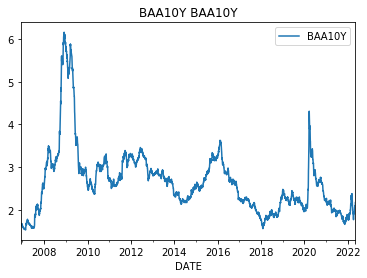

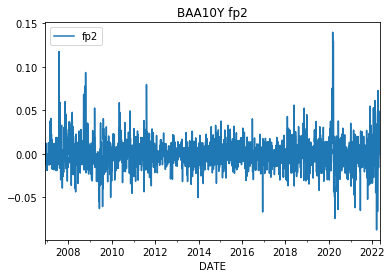

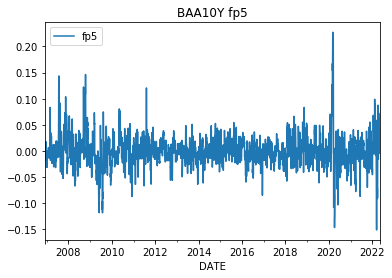

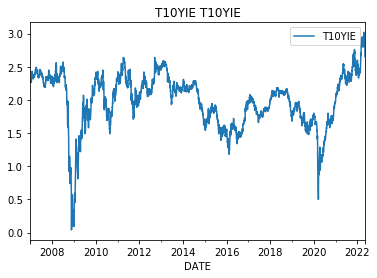

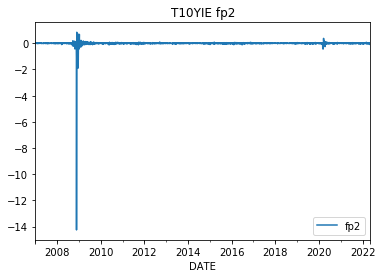

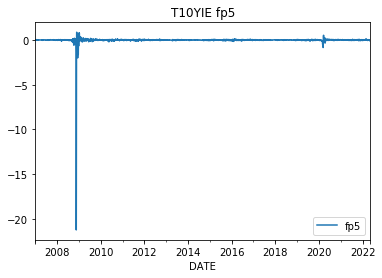

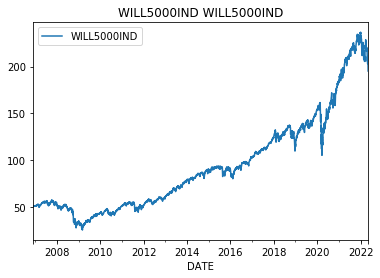

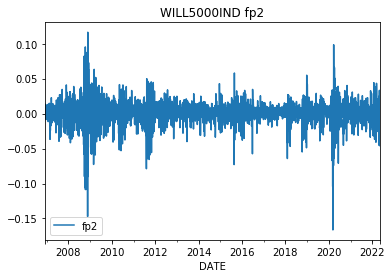

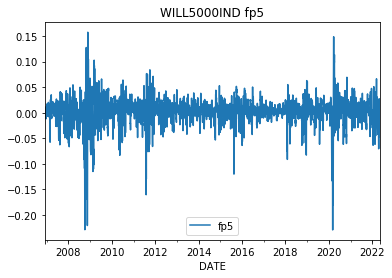

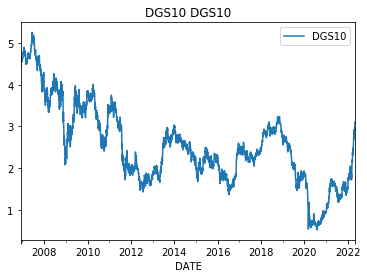

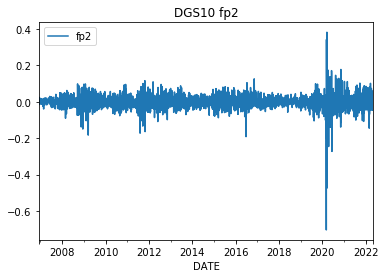

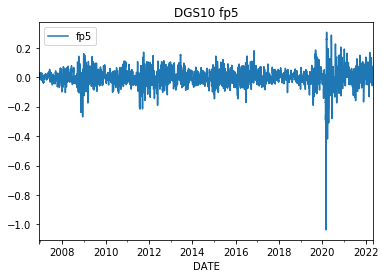

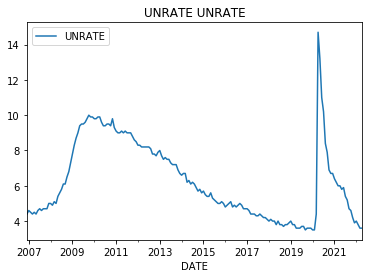

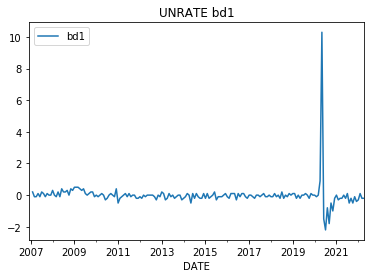

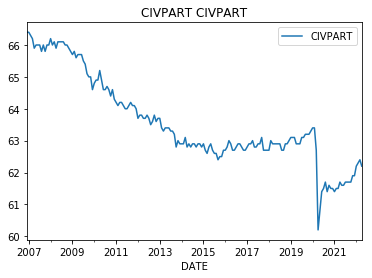

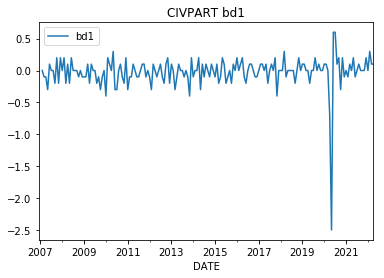

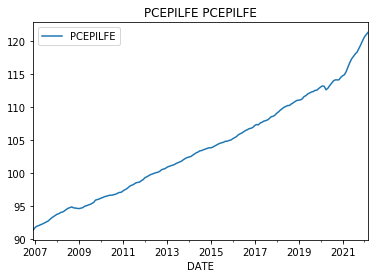

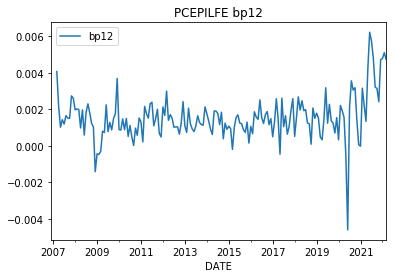

In [3]:


def transform_fred_dateseries( series_dict, series_key, period, is_pct , col_name , forward_shift = 1):
    
    df_series = series_dict[ series_key]
    
    if is_pct:
        df_series[ col_name ] = df_series[series_key].pct_change( periods = period )
        if period < 0:
            df_series[ col_name ] = -1 * df_series[ col_name]
        df_series[ col_name ] = df_series[col_name ].shift( periods = forward_shift)  # Forward shift
    else:
        df_series[ col_name ] = df_series[series_key].diff( periods = period )
        
        if period < 0:
            df_series[ col_name ] = -1 * df_series[ col_name]
        df_series[ col_name ] = df_series[col_name ].shift( periods = forward_shift)  # Forward shift

transform_fred_dateseries( dict_series, "BAA10Y", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "BAA10Y", -5,  is_pct = True, col_name = "fp5")

transform_fred_dateseries( dict_series, "T10YIE", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "T10YIE", -5,  is_pct = True, col_name = "fp5")

transform_fred_dateseries( dict_series, "WILL5000IND", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "WILL5000IND", -5,  is_pct = True, col_name = "fp5")

transform_fred_dateseries( dict_series, "DGS10", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "DGS10", -5,  is_pct = True, col_name = "fp5")

#
# Look back 1 month for Labor Participation Rate.  Use absolute rate change.
# 
# Join the monthly FOMC meeting to the same-month-CIVPART value and compare:
# sentiment Y of the FOMC and its prior-period change dY vs.  bd1 of the same-month-CIVPART 
#  
# Check if bd1 predicts dY
transform_fred_dateseries( dict_series, "CIVPART", 1,  is_pct = False, col_name = "bd1")

# Join the monthly FOMC meeting to the same-month-UNRATE value and compare:
# sentiment Y of the FOMC and its prior-period change dY vs.  bd1 of the same-month-UNRATE
#  
# Check if bd1 predicts dY
transform_fred_dateseries( dict_series, "UNRATE", 1,  is_pct = False, col_name = "bd1")

#
#  PCEPILFE is released monthly on a backward looking basis near the end of the following month.
#  E.g.
#        PCE[ Jan 2022] is published late Feb 2022 and would be available for an March 2022 FOMC meeting.
#
#  So we would shift the 12 month change in Jan 2022 PCEILFE to March 2022 bp12 data point.
#  i.e. use a 2 month forward shift
#
#  Regress if bp12 predicts change in sentiment dY
transform_fred_dateseries( dict_series, "PCEPILFE", 1,  is_pct = True, col_name = "bp12", forward_shift = 2)


#
# Display plots of all the time series and their transforms.
# 
# Outer loop is the series key
for v in dict_series:
    
    # inner loop is all data columns
    # only works if date is an index - not a column
    for u in dict_series[v]:
        
        if u != "DATE":
            dict_series[v].plot( x = "DATE", y = u)
            plt.title(v + " " + u)
            plt.show()


## Specifying the Regressions

We implement the dataframes containing the variables to be regressed below.

* The sentiment indicator is put into a dataframe called `df_sentiment`

* The market variables to be regressed are aligned by date.

We use the pandas `merge_asof` to do approximate date matching correctly.
Its logic aligns each FOMC date to the closest prior date of each other published financial or economic time series. 

Each univariate regression is displayed below for analysis using a scatter plot.

In [4]:
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore

# Get the true sentiment scores produced from running the Loughran-McDonald financial library on the FOMC statements for polarity
derived_data_dir = "../derived"
fomc_statements_file = derived_data_dir + "/" + "FOMC_statements_with_sentiment_score.csv"
df_fomc_statements_raw = pd.read_csv( fomc_statements_file , parse_dates=[1], header = 0)
df_fomc_statements_raw

,statement_id,date,year,chairperson,text,length,text_token,text_token_score_lm,score_lm_diff
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,173,federal open market committee decided today ke...,1.000,NaN
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,162,federal open market committee decided today ke...,0.000,-1.000
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,161,federal open market committee decided today ke...,-0.200,-0.200
3,4,2007-06-28,2007,Bernanke,the federal open market committee decided toda...,175,federal open market committee decided today ke...,0.333,0.533
4,5,2007-08-07,2007,Bernanke,the federal open market committee decided toda...,204,federal open market committee decided today ke...,-0.143,-0.476
...,...,...,...,...,...,...,...,...,...
121,122,2021-11-03,2021,Powell,the federal reserve is committed to using its ...,614,federal reserve committed using full range too...,0.273,-0.167
122,123,2021-12-15,2021,Powell,the federal reserve is committed to using its ...,521,federal reserve committed using full range too...,0.200,-0.073
123,124,2022-01-26,2022,Powell,indicators of economic activity and employment...,430,indicators economic activity employment contin...,0.125,-0.075
124,125,2022-03-16,2022,Powell,indicators of economic activity and employment...,348,indicators economic activity employment contin...,-0.143,-0.268


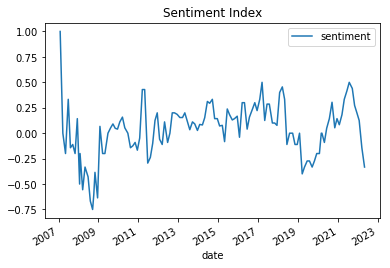

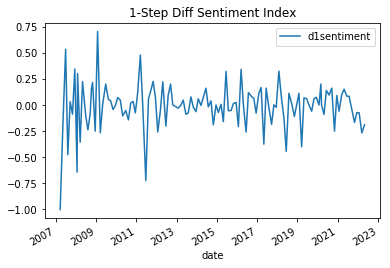

In [5]:
# Extract the column from the input that represents the Loughran-McDonald sentiment scores 
df_sentiment = pd.DataFrame( df_fomc_statements_raw["date"] )
df_sentiment["sentiment"] = df_fomc_statements_raw["text_token_score_lm"]

# Plot the sentiment scores as a time series
df_sentiment.plot(x = "date", y = "sentiment")
plt.title("Sentiment Index")
plt.show()

# Calculate the difference from previous row
df_sentiment[ "d1sentiment" ] = df_sentiment["sentiment"].diff( periods = 1 )
df_sentiment

# Plot the sentiment score difference as a time series
df_sentiment.plot(x = "date", y = "d1sentiment")
plt.title("1-Step Diff Sentiment Index")
plt.show()

In [6]:
#
#  Merge dates of the Sentiment and Market Indicator to construct a regression.
#
#  Let sentiment variable be denoted Z
#  
#  For macroeconomic variables Y:   we estimate the model  Z = f(Y).   Explain sentiment in terms of macroeconomic variable.
#
#  For financial market variable X:  we estimate the model X = g(Z).  Explain financial variable in terms of sentiment variable.
#
#  Date Alignment for macroeconomic model fit:
#      for each FOMC date f(i) and the prior FOMC meeting date f(i-1) 
#           find the macroeconomic variable for the same month and year.
#
#      Estimate a model based on the change in sentiment Z[f(i)] - Z[f(i-1)]
#
#      Compare to the prior change in macroeconomic bd1 (backward difference 1 lag) or 
#      bp12 (backward proportional change 12 months)
# -------------------------------------------------------------------

## **CIVPART**

Generate the linear regression plot of the backward difference lag of one for the Labor Force Participation Rate against the backward difference of the FOMC statement sentiment score. The residuals plot of the linear regression model. Using the `statsmodels` module the summary statistics are displayed for the linear regression model.

We use the `ols` function, estimation by ordinary least squares, from the `statsmodels` module to build the linear regression models.

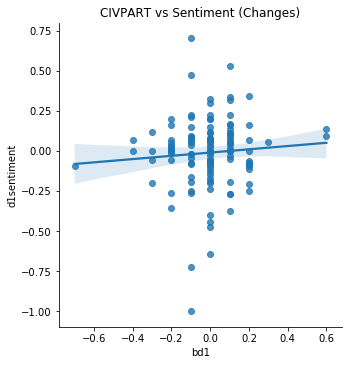

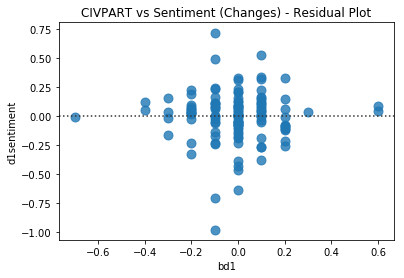

                            OLS Regression Results                            
Dep. Variable:            d1sentiment   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7507
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.388
Time:                        15:26:57   Log-Likelihood:                 13.760
No. Observations:                 125   AIC:                            -23.52
Df Residuals:                     123   BIC:                            -17.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0095      0.020     -0.486      0.6

In [7]:
# ----- CIVPART -----

CIVPART = dict_series["CIVPART"]

df_sent_CIVPART = pd.merge_asof(df_sentiment, CIVPART, left_on = "date", right_on = "DATE")

#print(df_sent_CIVPART.tail(10) )

sns.lmplot( y= 'd1sentiment', x = "bd1", data = df_sent_CIVPART, fit_reg=True, legend=True)
plt.title("CIVPART vs Sentiment (Changes)")
plt.show()

# https://seaborn.pydata.org/tutorial/regression.html
sns.residplot(y= 'd1sentiment', x = "bd1", data = df_sent_CIVPART, scatter_kws={"s": 80})
plt.title("CIVPART vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_CIVPART_bd1 = sm.OLS(df_sent_CIVPART['d1sentiment'], sm.add_constant(df_sent_CIVPART['bd1']), missing='drop')
mod_fit_CIVPART_bd1 = mod_CIVPART_bd1.fit()
print(mod_fit_CIVPART_bd1.summary())

In [8]:
mod_CIVPART_bd1_r2 = mod_fit_CIVPART_bd1.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_CIVPART_bd1_r2))

The model's R-squared value: 0.006.

In [9]:
mod_CIVPART_bd1_pval = mod_fit_CIVPART_bd1.pvalues['bd1']
md("The p-value of independent variable: {:.3f}.".format(mod_CIVPART_bd1_pval))

The p-value of independent variable: 0.388.

In [10]:
mod_CIVPART_bd1_var_coef = mod_fit_CIVPART_bd1.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_CIVPART_bd1_var_coef))

The coefficient of independent variable: 0.102.

The resulting $R^2$ value is 0.006. The very low result shows the variance in the sentiment score explains essentially none of the variance in the dependent variable.

The coefficient for the sentiment difference variables is 0.0596 with a P value of over 35% indicating we cannot reject the null hypothesis. This indicates there is 61% probability of being correct that the variable is having some effect much lower than the 95% significance level.

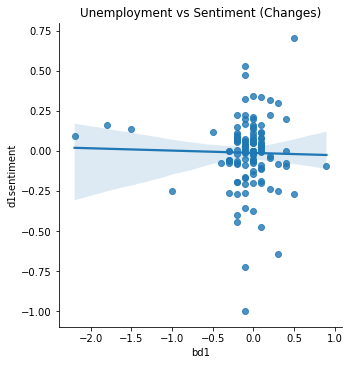

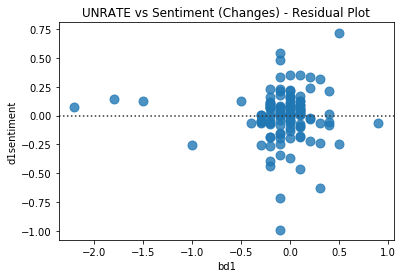

                            OLS Regression Results                            
Dep. Variable:            d1sentiment   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                   0.06733
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.796
Time:                        15:26:58   Log-Likelihood:                 13.414
No. Observations:                 125   AIC:                            -22.83
Df Residuals:                     123   BIC:                            -17.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0116      0.020     -0.583      0.5

In [11]:
# ----- UNRATE -----

UNRATE = dict_series["UNRATE"]

df_sent_UNRATE = pd.merge_asof(df_sentiment, UNRATE, left_on = "date", right_on = "DATE")

#print(df_sent_UNRATE.tail(10) )

sns.lmplot( y= 'd1sentiment', x = "bd1", data = df_sent_UNRATE, fit_reg=True, legend=True)
plt.title("Unemployment vs Sentiment (Changes)")
plt.show()

sns.residplot( y= 'd1sentiment', x = "bd1", data = df_sent_UNRATE, scatter_kws={"s": 80})
plt.title("UNRATE vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_UNRATE_bd1 = sm.OLS(df_sent_UNRATE['d1sentiment'], sm.add_constant(df_sent_UNRATE['bd1']), missing='drop')
mod_fit_UNRATE_bd1 = mod_UNRATE_bd1.fit()
print(mod_fit_UNRATE_bd1.summary())

In [12]:
mod_UNRATE_bd1_r2 = mod_fit_UNRATE_bd1.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_UNRATE_bd1_r2))

The model's R-squared value: 0.001.

In [13]:
mod_UNRATE_bd1_pval = mod_fit_UNRATE_bd1.pvalues['bd1']
md("The p-value of independent variable: {:.3f}.".format(mod_UNRATE_bd1_pval))

The p-value of independent variable: 0.796.

In [14]:
mod_UNRATE_bd1_var_coef = mod_fit_UNRATE_bd1.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_UNRATE_bd1_var_coef))

The coefficient of independent variable: -0.014.

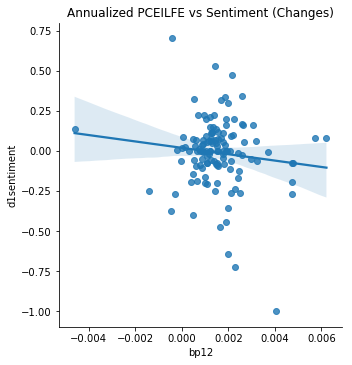

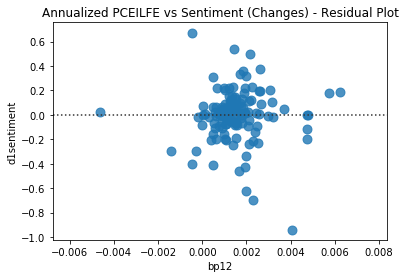

                            OLS Regression Results                            
Dep. Variable:            d1sentiment   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.739
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.190
Time:                        15:27:00   Log-Likelihood:                 14.257
No. Observations:                 125   AIC:                            -24.51
Df Residuals:                     123   BIC:                            -18.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0200      0.030      0.659      0.5

In [15]:
# ----- PCEPILFE -----

PCEPILFE = dict_series["PCEPILFE"]

df_sent_PCEPILFE = pd.merge_asof(df_sentiment, PCEPILFE, left_on = "date", right_on = "DATE")

#print(df_sent_PCEPILFE.tail(10) )

sns.lmplot( y= 'd1sentiment', x = "bp12", data = df_sent_PCEPILFE, fit_reg=True, legend=True)
plt.title("Annualized PCEILFE vs Sentiment (Changes)")
plt.show()

sns.residplot( y= 'd1sentiment', x = "bp12", data = df_sent_PCEPILFE, scatter_kws={"s": 80})
plt.title("Annualized PCEILFE vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_PCEPILFE_bp12 = sm.OLS(df_sent_PCEPILFE['d1sentiment'], sm.add_constant(df_sent_PCEPILFE['bp12']), missing='drop')
mod_fit_PCEPILFE_bp12 = mod_PCEPILFE_bp12.fit()
print(mod_fit_PCEPILFE_bp12.summary())

In [16]:
mod_PCEPILFE_bp12_r2 = mod_fit_PCEPILFE_bp12.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_PCEPILFE_bp12_r2))

The model's R-squared value: 0.014.

In [17]:
mod_PCEPILFE_bp12_pval = mod_fit_PCEPILFE_bp12.pvalues['bp12']
md("The p-value of independent variable: {:.3f}.".format(mod_PCEPILFE_bp12_pval))

The p-value of independent variable: 0.190.

In [18]:
mod_PCEPILFE_bp12_var_coef = mod_fit_PCEPILFE_bp12.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_PCEPILFE_bp12_var_coef))

The coefficient of independent variable: -19.888.

In [19]:
#  Date Alignment for financial model fit:
#      for each FOMC date f(i):
#           find the financial variable for the date.  Most variables are available daily.
#
#      Estimate a model on the change in the financial variable as a result of the change in sentiment.
#
#      One important problem is that FOMC statement is released during the market hours at 2pm EST.
#      Thus, the financial variable recorded at end of day on the same day as the FOMC statement already reflects
#      the sentiment impact.
#      Therefore, we need to compare the change in response of the financial variable across
#      a date before the FOMC statement versus 1 or more days after the FOMC statement.
#
#      We use 2 comparison periods to measure the change:
#          bp2:   change from 1 day before FOMC date to 1 day AFTER FOMC date
#          bp5:   change from 1 day before FOMC date to 4 days AFTER FOMC date
#      For ease of date alignment, we shifted both bp2 and bp5 by 1 day forward.
#      So the value of bp2 and bp5 on a FOMC date is actually spanning the intended time period.
# ----------------------------------------------------------

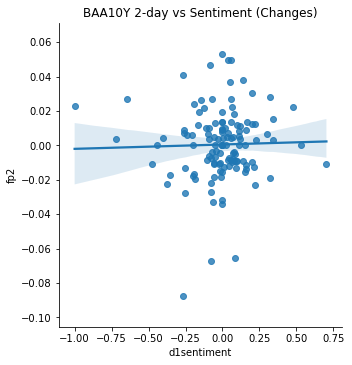

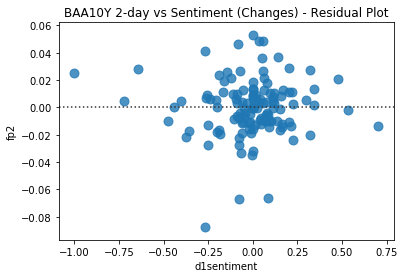

                            OLS Regression Results                            
Dep. Variable:                    fp2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.08551
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.770
Time:                        15:27:01   Log-Likelihood:                 306.50
No. Observations:                 125   AIC:                            -609.0
Df Residuals:                     123   BIC:                            -603.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0005      0.002      0.261      

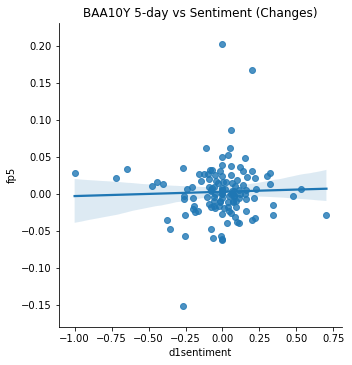

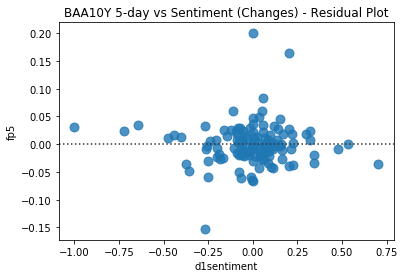

                            OLS Regression Results                            
Dep. Variable:                    fp5   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1371
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.712
Time:                        15:27:03   Log-Likelihood:                 229.84
No. Observations:                 124   AIC:                            -455.7
Df Residuals:                     122   BIC:                            -450.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0026      0.003      0.751      

In [20]:
# ----- BAA10Y -----

BAA10Y = dict_series["BAA10Y"]

df_sent_BAA10Y = pd.merge_asof(df_sentiment, BAA10Y, left_on = "date", right_on = "DATE")

#print(df_sent_BAA10Y.tail(10) )

sns.lmplot( x= 'd1sentiment', y = "fp2", data = df_sent_BAA10Y, fit_reg=True, legend=True)
plt.title("BAA10Y 2-day vs Sentiment (Changes)")
plt.show()

sns.residplot( x= 'd1sentiment', y = "fp2", data = df_sent_BAA10Y, scatter_kws={"s": 80})
plt.title("BAA10Y 2-day vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_BAA10Y_fp2 = sm.OLS(df_sent_BAA10Y['fp2'], sm.add_constant(df_sent_BAA10Y['d1sentiment']), missing='drop')
mod_fit_BAA10Y_fp2 = mod_BAA10Y_fp2.fit()
print(mod_fit_BAA10Y_fp2.summary())

sns.lmplot( x= 'd1sentiment', y = "fp5", data = df_sent_BAA10Y, fit_reg=True, legend=True)
plt.title("BAA10Y 5-day vs Sentiment (Changes)")
plt.show()

sns.residplot( x= 'd1sentiment', y = "fp5", data = df_sent_BAA10Y, scatter_kws={"s": 80})
plt.title("BAA10Y 5-day vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_BAA10Y_fp5 = sm.OLS(df_sent_BAA10Y['fp5'], sm.add_constant(df_sent_BAA10Y['d1sentiment']), missing='drop')
mod_fit_BAA10Y_fp5 = mod_BAA10Y_fp5.fit()
print(mod_fit_BAA10Y_fp5.summary())

In [21]:
# fp2
mod_BAA10Y_fp2_r2 = mod_fit_BAA10Y_fp2.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_BAA10Y_fp2_r2))

The model's R-squared value: 0.001.

In [22]:
mod_BAA10Y_fp2_pval = mod_fit_BAA10Y_fp2.pvalues['d1sentiment']
md("The p-value of independent variable: {:.3f}.".format(mod_BAA10Y_fp2_pval))

The p-value of independent variable: 0.770.

In [23]:
mod_BAA10Y_fp2_var_coef = mod_fit_BAA10Y_fp2.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_BAA10Y_fp2_var_coef))

The coefficient of independent variable: 0.003.

In [24]:
# fp5
mod_BAA10Y_fp5_r2 = mod_fit_BAA10Y_fp5.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_BAA10Y_fp5_r2))

The model's R-squared value: 0.001.

In [25]:
mod_BAA10Y_fp5_pval = mod_fit_BAA10Y_fp5.pvalues['d1sentiment']
md("The p-value of independent variable: {:.3f}.".format(mod_BAA10Y_fp5_pval))

The p-value of independent variable: 0.712.

In [26]:
mod_BAA10Y_fp5_var_coef = mod_fit_BAA10Y_fp5.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_BAA10Y_fp5_var_coef))

The coefficient of independent variable: 0.006.

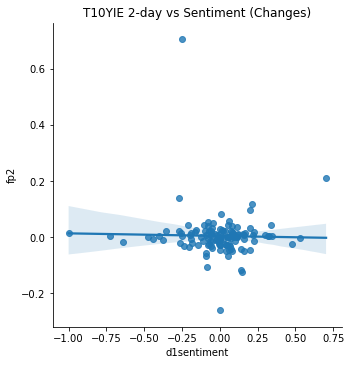

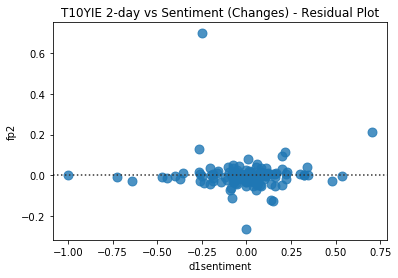

                            OLS Regression Results                            
Dep. Variable:                    fp2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.08128
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.776
Time:                        15:27:04   Log-Likelihood:                 140.28
No. Observations:                 125   AIC:                            -276.6
Df Residuals:                     123   BIC:                            -270.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0047      0.007      0.664      

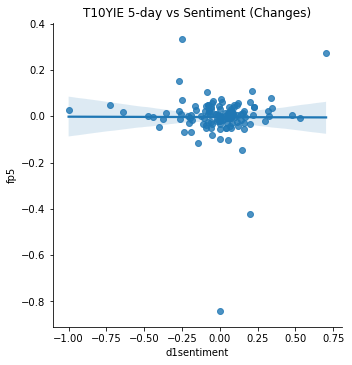

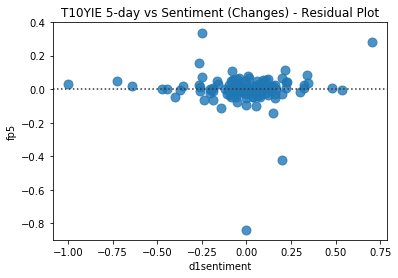

                            OLS Regression Results                            
Dep. Variable:                    fp5   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                  0.001861
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.966
Time:                        15:27:05   Log-Likelihood:                 108.03
No. Observations:                 125   AIC:                            -212.1
Df Residuals:                     123   BIC:                            -206.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0040      0.009     -0.433      

In [27]:
# ----- T10YIE -----

T10YIE = dict_series["T10YIE"]

df_sent_T10YIE = pd.merge_asof(df_sentiment, T10YIE, left_on = "date", right_on = "DATE")

#print(df_sent_T10YIE.tail(10) )

sns.lmplot( x= 'd1sentiment', y = "fp2", data = df_sent_T10YIE, fit_reg=True, legend=True)
plt.title("T10YIE 2-day vs Sentiment (Changes)")
plt.show()

sns.residplot( x= 'd1sentiment', y = "fp2", data = df_sent_T10YIE, scatter_kws={"s": 80})
plt.title("T10YIE 2-day vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_T10YIE_fp2 = sm.OLS(df_sent_T10YIE['fp2'], sm.add_constant(df_sent_T10YIE['d1sentiment']), missing='drop')
mod_fit_T10YIE_fp2 = mod_T10YIE_fp2.fit()
print(mod_fit_T10YIE_fp2.summary())

sns.lmplot( x= 'd1sentiment', y = "fp5", data = df_sent_T10YIE, fit_reg=True, legend=True)
plt.title("T10YIE 5-day vs Sentiment (Changes)")
plt.show()

sns.residplot( x= 'd1sentiment', y = "fp5", data = df_sent_T10YIE, scatter_kws={"s": 80})
plt.title("T10YIE 5-day vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_T10YIE_fp5 = sm.OLS(df_sent_T10YIE['fp5'], sm.add_constant(df_sent_T10YIE['d1sentiment']), missing='drop')
mod_fit_T10YIE_fp5 = mod_T10YIE_fp5.fit()
print(mod_fit_T10YIE_fp5.summary())

In [28]:
#fp2
mod_T10YIE_fp2_r2 = mod_fit_T10YIE_fp2.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_T10YIE_fp2_r2))

The model's R-squared value: 0.001.

In [29]:
mod_T10YIE_fp2_pval = mod_fit_T10YIE_fp2.pvalues['d1sentiment']
md("The p-value of independent variable: {:.3f}.".format(mod_T10YIE_fp2_pval))

The p-value of independent variable: 0.776.

In [30]:
mod_T10YIE_fp2_var_coef = mod_fit_T10YIE_fp2.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_T10YIE_fp2_var_coef))

The coefficient of independent variable: -0.009.

In [31]:
#fp5
mod_T10YIE_fp5_r2 = mod_fit_T10YIE_fp5.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_T10YIE_fp5_r2))

The model's R-squared value: 0.000.

In [32]:
mod_T10YIE_fp5_pval = mod_fit_T10YIE_fp5.pvalues['d1sentiment']
md("The p-value of independent variable: {:.3f}.".format(mod_T10YIE_fp5_pval))

The p-value of independent variable: 0.966.

In [33]:
mod_T10YIE_fp5_var_coef = mod_fit_T10YIE_fp5.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_T10YIE_fp5_var_coef))

The coefficient of independent variable: -0.002.

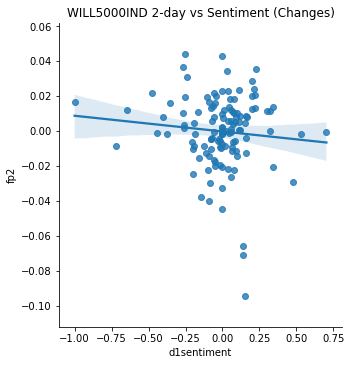

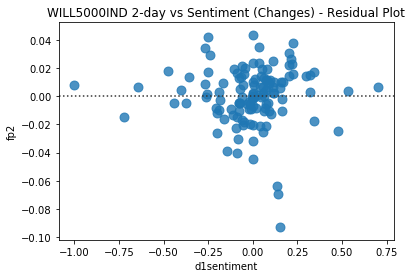

                            OLS Regression Results                            
Dep. Variable:                    fp2   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.126
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.291
Time:                        15:27:06   Log-Likelihood:                 308.91
No. Observations:                 125   AIC:                            -613.8
Df Residuals:                     123   BIC:                            -608.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0003      0.002     -0.137      

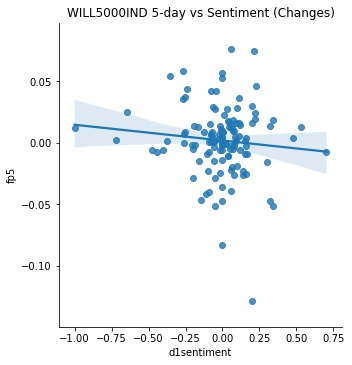

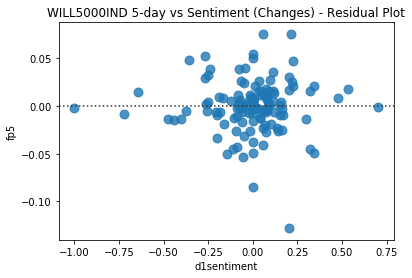

                            OLS Regression Results                            
Dep. Variable:                    fp5   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.243
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.267
Time:                        15:27:08   Log-Likelihood:                 268.82
No. Observations:                 124   AIC:                            -533.6
Df Residuals:                     122   BIC:                            -528.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0019      0.003      0.763      

In [34]:
# ----- WILL5000IND -----

WILL5000IND = dict_series["WILL5000IND"]

df_sent_WILL5000IND = pd.merge_asof(df_sentiment, WILL5000IND, left_on = "date", right_on = "DATE")

#print(df_sent_WILL5000IND.tail(10) )

sns.lmplot( x= 'd1sentiment', y = "fp2", data = df_sent_WILL5000IND, fit_reg=True, legend=True)
plt.title("WILL5000IND 2-day vs Sentiment (Changes)")
plt.show()

sns.residplot( x= 'd1sentiment', y = "fp2", data = df_sent_WILL5000IND, scatter_kws={"s": 80})
plt.title("WILL5000IND 2-day vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_WILL5000IND_fp2 = sm.OLS(df_sent_WILL5000IND['fp2'], sm.add_constant(df_sent_WILL5000IND['d1sentiment']), missing='drop')
mod_fit_WILL5000IND_fp2 = mod_WILL5000IND_fp2.fit()
print(mod_fit_WILL5000IND_fp2.summary())

sns.lmplot( x= 'd1sentiment', y = "fp5", data = df_sent_WILL5000IND, fit_reg=True, legend=True)
plt.title("WILL5000IND 5-day vs Sentiment (Changes)")
plt.show()

sns.residplot( x= 'd1sentiment', y = "fp5", data = df_sent_WILL5000IND, scatter_kws={"s": 80})
plt.title("WILL5000IND 5-day vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_WILL5000IND_fp5 = sm.OLS(df_sent_WILL5000IND['fp5'], sm.add_constant(df_sent_WILL5000IND['d1sentiment']), missing='drop')
mod_fit_WILL5000IND_fp5 = mod_WILL5000IND_fp5.fit()
print(mod_fit_WILL5000IND_fp5.summary())

In [35]:
#fp2
mod_WILL5000IND_fp2_r2 = mod_fit_WILL5000IND_fp2.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_WILL5000IND_fp2_r2))

The model's R-squared value: 0.009.

In [36]:
mod_WILL5000IND_fp2_pval = mod_fit_WILL5000IND_fp2.pvalues['d1sentiment']
md("The p-value of independent variable: {:.3f}.".format(mod_WILL5000IND_fp2_pval))

The p-value of independent variable: 0.291.

In [37]:
mod_WILL5000IND_fp2_var_coef = mod_fit_WILL5000IND_fp2.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_WILL5000IND_fp2_var_coef))

The coefficient of independent variable: -0.009.

In [38]:
#fp5
mod_WILL5000IND_fp5_r2 = mod_fit_WILL5000IND_fp5.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_WILL5000IND_fp5_r2))

The model's R-squared value: 0.010.

In [39]:
mod_WILL5000IND_fp5_pval = mod_fit_WILL5000IND_fp5.pvalues['d1sentiment']
md("The p-value of independent variable: {:.3f}.".format(mod_WILL5000IND_fp5_pval))

The p-value of independent variable: 0.267.

In [40]:
mod_WILL5000IND_fp5_var_coef = mod_fit_WILL5000IND_fp5.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_WILL5000IND_fp5_var_coef))

The coefficient of independent variable: -0.013.

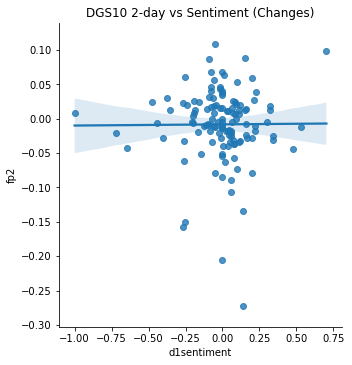

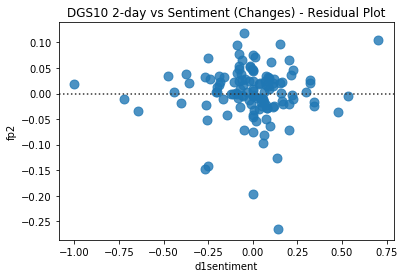

                            OLS Regression Results                            
Dep. Variable:                    fp2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                  0.006063
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.938
Time:                        15:27:09   Log-Likelihood:                 189.57
No. Observations:                 125   AIC:                            -375.1
Df Residuals:                     123   BIC:                            -369.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0084      0.005     -1.747      

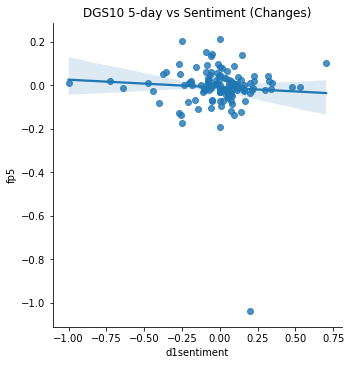

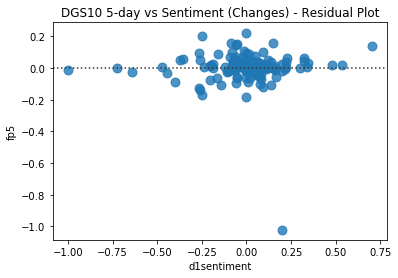

                            OLS Regression Results                            
Dep. Variable:                    fp5   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5810
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.447
Time:                        15:27:11   Log-Likelihood:                 93.522
No. Observations:                 124   AIC:                            -183.0
Df Residuals:                     122   BIC:                            -177.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0096      0.010     -0.929      

In [41]:
# ----- DGS10 -----

DGS10 = dict_series["DGS10"]

df_sent_DGS10 = pd.merge_asof(df_sentiment, DGS10, left_on = "date", right_on = "DATE")

#print(df_sent_DGS10.tail(10) )

sns.lmplot( x= 'd1sentiment', y = "fp2", data = df_sent_DGS10, fit_reg=True, legend=True)
plt.title("DGS10 2-day vs Sentiment (Changes)")
plt.show()

sns.residplot( x= 'd1sentiment', y = "fp2", data = df_sent_DGS10, scatter_kws={"s": 80})
plt.title("DGS10 2-day vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_DGS10_fp2 = sm.OLS(df_sent_DGS10['fp2'], sm.add_constant(df_sent_DGS10['d1sentiment']), missing='drop')
mod_fit_DGS10_fp2 = mod_DGS10_fp2.fit()
print(mod_fit_DGS10_fp2.summary())

sns.lmplot( x= 'd1sentiment', y = "fp5", data = df_sent_DGS10, fit_reg=True, legend=True)
plt.title("DGS10 5-day vs Sentiment (Changes)")
plt.show()

sns.residplot( x= 'd1sentiment', y = "fp5", data = df_sent_DGS10, scatter_kws={"s": 80})
plt.title("DGS10 5-day vs Sentiment (Changes) - Residual Plot")
plt.show()

# Generate linear regression model
mod_DGS10_fp5 = sm.OLS(df_sent_DGS10['fp5'], sm.add_constant(df_sent_DGS10['d1sentiment']), missing='drop')
mod_fit_DGS10_fp5 = mod_DGS10_fp5.fit()
print(mod_fit_DGS10_fp5.summary())

In [42]:
#fp2
mod_DGS10_fp2_r2 = mod_fit_DGS10_fp2.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_DGS10_fp2_r2))

The model's R-squared value: 0.000.

In [43]:
mod_DGS10_fp2_pval = mod_fit_DGS10_fp2.pvalues['d1sentiment']
md("The p-value of independent variable: {:.3f}.".format(mod_DGS10_fp2_pval))

The p-value of independent variable: 0.938.

In [44]:
mod_DGS10_fp2_var_coef = mod_fit_DGS10_fp2.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_DGS10_fp2_var_coef))

The coefficient of independent variable: 0.002.

In [45]:
#fp5
mod_DGS10_fp5_r2 = mod_fit_DGS10_fp5.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_DGS10_fp5_r2))

The model's R-squared value: 0.005.

In [46]:
mod_DGS10_fp5_pval = mod_fit_DGS10_fp5.pvalues['d1sentiment']
md("The p-value of independent variable: {:.3f}.".format(mod_DGS10_fp5_pval))

The p-value of independent variable: 0.447.

In [47]:
mod_DGS10_fp5_var_coef = mod_fit_DGS10_fp5.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_DGS10_fp5_var_coef))

The coefficient of independent variable: -0.036.

In [48]:
list_models = ['CIVPART_bd1', 'UNRATE_bd1', 'PCEPILFE_bp12', 'BAA10Y_fp2', 'BAA10Y_fp5',
               'T10YIE_fp2', 'T10YIE_fp5', 'WILL5000IND_fp2', 'WILL5000IND_fp5', 'DGS10_fp2', 'DGS10_fp5']
list_r2 = [mod_CIVPART_bd1_r2, mod_UNRATE_bd1_r2, mod_PCEPILFE_bp12_r2, mod_BAA10Y_fp2_r2, mod_BAA10Y_fp5_r2,
           mod_T10YIE_fp2_r2, mod_T10YIE_fp5_r2, mod_WILL5000IND_fp2_r2, mod_WILL5000IND_fp5_r2, mod_DGS10_fp2_r2, mod_DGS10_fp5_r2]
list_coef = [mod_CIVPART_bd1_var_coef, mod_UNRATE_bd1_var_coef, mod_PCEPILFE_bp12_var_coef, mod_BAA10Y_fp2_var_coef, mod_BAA10Y_fp5_var_coef,
             mod_T10YIE_fp2_var_coef, mod_T10YIE_fp5_var_coef, mod_WILL5000IND_fp2_var_coef, mod_WILL5000IND_fp5_var_coef, mod_DGS10_fp2_var_coef, mod_DGS10_fp5_var_coef]
list_pval = [mod_CIVPART_bd1_pval, mod_UNRATE_bd1_pval, mod_PCEPILFE_bp12_pval, mod_BAA10Y_fp2_pval, mod_BAA10Y_fp5_pval,
             mod_T10YIE_fp2_pval, mod_T10YIE_fp5_pval, mod_WILL5000IND_fp2_pval, mod_WILL5000IND_fp5_pval, mod_DGS10_fp2_pval, mod_DGS10_fp5_pval]

In [49]:
model_results_df = pd.DataFrame(
    {'Model': list_models,
     'R-squared': list_r2,
     'Variable Coefficient': list_coef,
     'Variable Coefficient P-value': list_pval,
    })

In [50]:
model_results_df

,Model,R-squared,Variable Coefficient,Variable Coefficient P-value
0,CIVPART_bd1,0.006066,0.101714,0.387942
1,UNRATE_bd1,0.000547,-0.014406,0.795701
2,PCEPILFE_bp12,0.013943,-19.888330,0.189691
3,BAA10Y_fp2,0.000695,0.002527,0.770454
4,BAA10Y_fp5,0.001123,0.005838,0.711816
5,T10YIE_fp2,0.000660,-0.009314,0.776044
6,T10YIE_fp5,0.000015,-0.001824,0.965658
7,WILL5000IND_fp2,0.009072,-0.008996,0.290706
8,WILL5000IND_fp5,0.010089,-0.012839,0.267008
9,DGS10_fp2,0.000049,0.001715,0.938063


In [51]:
# ========================================
# Scratch work for the statsmodels linear regression and summary output
# ========================================

# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS
# sm.OLS(dependent, independent, missing='drop')
mod = sm.OLS(df_sent_DGS10['fp2'], df_sent_DGS10['d1sentiment'], missing='drop')
results = mod.fit()
#results.params
#results.tvalues
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    fp2   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.008
Method:                 Least Squares   F-statistic:                            0.02634
Date:                Fri, 13 May 2022   Prob (F-statistic):                       0.871
Time:                        15:27:11   Log-Likelihood:                          188.04
No. Observations:                 125   AIC:                                     -374.1
Df Residuals:                     124   BIC:                                     -371.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [52]:
from statsmodels.graphics.gofplots import ProbPlot

# For cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

# Class to generate the linear regression summary plots
class LinearRegressionSummaryPlots:
   
    # Constructor 
    def __init__(self, dataframe, column, model_results):
        
        self.dataframe = dataframe
        self.column = column
        self.model_results = model_results
        # Initial calculations required for some of the plots
        # fitted values (need a constant term for intercept)
        self.model_fitted_y = results.fittedvalues
        # model residuals
        self.model_residuals = results.resid
        # normalized residuals
        self.model_norm_residuals = results.get_influence().resid_studentized_internal
        # absolute squared normalized residuals
        self.model_norm_residuals_abs_sqrt = np.sqrt(np.abs(self.model_norm_residuals))
        # absolute residuals
        self.model_abs_resid = np.abs(self.model_residuals)
        # leverage, from statsmodels internals
        self.model_leverage = results.get_influence().hat_matrix_diag
        # cook's distance, from statsmodels internals
        self.model_cooks = results.get_influence().cooks_distance[0]


    # Residuals vs Fitted Plot
    def display_resdiduals_vs_fitted_plot(self):
        plot_lm_1 = plt.figure(1)
        plot_lm_1.set_figheight(8)
        plot_lm_1.set_figwidth(12)

        plot_lm_1.axes[0] = sns.residplot(self.model_fitted_y, self.column, data=self.dataframe[1:],
                                          lowess=True,
                                          scatter_kws={'alpha': 0.5},
                                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

        plot_lm_1.axes[0].set_title('Residuals vs Fitted')
        plot_lm_1.axes[0].set_xlabel('Fitted values')
        plot_lm_1.axes[0].set_ylabel('Residuals')

        # annotations
        abs_resid = self.model_abs_resid.sort_values(ascending=False)
        abs_resid_top_3 = abs_resid[:3]

        for i in abs_resid_top_3.index:
            plot_lm_1.axes[0].annotate(i,
                                       xy=(self.model_fitted_y[i],
                                           self.model_residuals[i]));
            
    def display_qq_plot(self):
        QQ = ProbPlot(self.model_norm_residuals)
        plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

        plot_lm_2.set_figheight(8)
        plot_lm_2.set_figwidth(12)

        plot_lm_2.axes[0].set_title('Normal Q-Q')
        plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
        plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.model_norm_residuals)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]

        for r, i in enumerate(abs_norm_resid_top_3):
            plot_lm_2.axes[0].annotate(i, 
                                       xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                           self.model_norm_residuals[i]));
            
    def display_scale_location_plot(self): 
        plot_lm_3 = plt.figure(3)
        plot_lm_3.set_figheight(8)
        plot_lm_3.set_figwidth(12)

        plt.scatter(self.model_fitted_y, self.model_norm_residuals_abs_sqrt, alpha=0.5)
        sns.regplot(self.model_fitted_y, self.model_norm_residuals_abs_sqrt,
                    scatter=False,
                    ci=False,
                    lowess=True,
                    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

        plot_lm_3.axes[0].set_title('Scale-Location')
        plot_lm_3.axes[0].set_xlabel('Fitted values')
        plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(self.model_norm_residuals_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

        for i in abs_sq_norm_resid_top_3:
            plot_lm_3.axes[0].annotate(i,
                                       xy=(self.model_fitted_y[i],
                                           self.model_norm_residuals_abs_sqrt[i]));
    
    def display_residuals_vs_leverage_plot(self):
        plot_lm_4 = plt.figure(4)
        plot_lm_4.set_figheight(8)
        plot_lm_4.set_figwidth(12)

        plt.scatter(self.model_leverage, self.model_norm_residuals, alpha=0.5)
        sns.regplot(self.model_leverage, self.model_norm_residuals,
                    scatter=False,
                    ci=False,
                    lowess=True,
                    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

        plot_lm_4.axes[0].set_xlim(0, 0.20)
        plot_lm_4.axes[0].set_ylim(-3, 5)
        plot_lm_4.axes[0].set_title('Residuals vs Leverage')
        plot_lm_4.axes[0].set_xlabel('Leverage')
        plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.model_cooks), 0)[:3]

        for i in leverage_top_3:
            plot_lm_4.axes[0].annotate(i,
                                       xy=(self.model_leverage[i],
                                           self.model_norm_residuals[i]))

        p = len(self.model_results.params) # number of model parameters

        graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
              np.linspace(0.001, 0.200, 50),
              'Cook\'s distance') # 0.5 line
        graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
              np.linspace(0.001, 0.200, 50)) # 1 line
        plt.legend(loc='upper right');

In [53]:
# Generate linear regression model
# scratch work - create model and results (aka fit)
mod_DGS10_fp2 = sm.OLS(df_sent_DGS10['fp2'], df_sent_DGS10['d1sentiment'], missing='drop')
results_DGS10_fp2 = mod_DGS10_fp2.fit()

df_sent_DGS10

,date,sentiment,d1sentiment,DATE,DGS10,fp2,fp5
0,2007-01-31,1.000,NaN,2007-01-31,4.83,-0.008264,-0.023061
1,2007-03-21,0.000,-1.000,2007-03-21,4.53,0.008696,0.012987
2,2007-05-09,-0.200,-0.200,2007-05-09,4.67,0.004301,0.016985
3,2007-06-28,0.333,0.533,2007-06-28,5.12,-0.011928,-0.007921
4,2007-08-07,-0.143,-0.476,2007-08-07,4.77,0.024793,0.012552
...,...,...,...,...,...,...,...
121,2021-11-03,0.273,-0.167,2021-11-03,1.60,-0.019608,-0.068493
122,2021-12-15,0.200,-0.073,2021-12-15,1.47,-0.000000,0.027027
123,2022-01-26,0.125,-0.075,2022-01-26,1.85,0.016575,0.016575
124,2022-03-16,-0.143,-0.268,2022-03-16,2.19,0.022727,0.096639


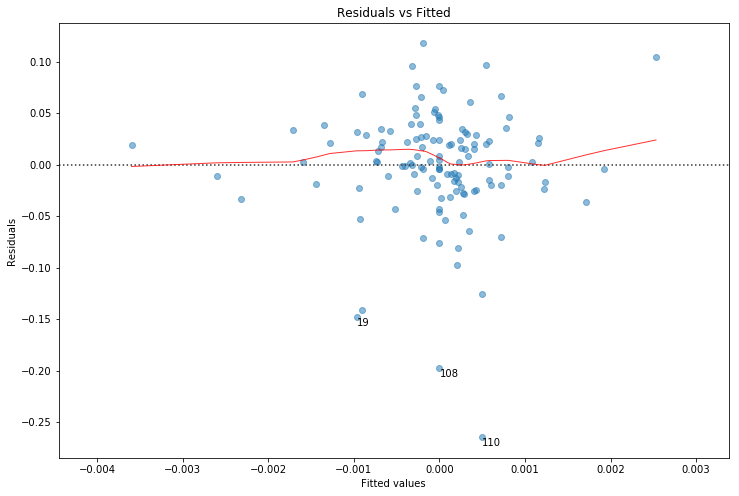

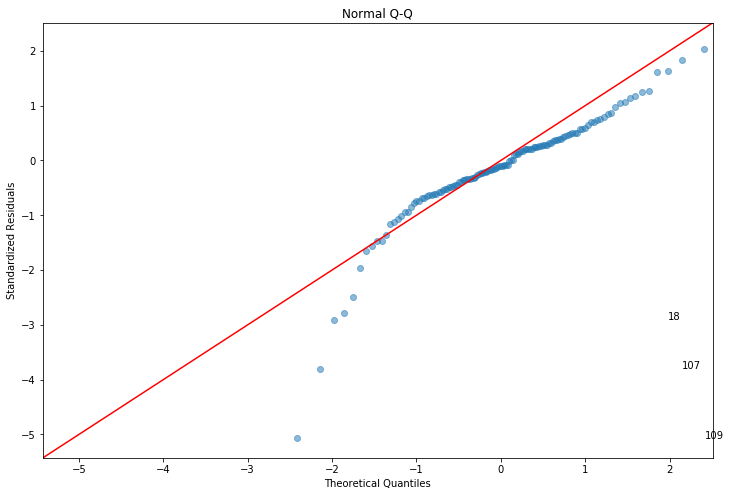

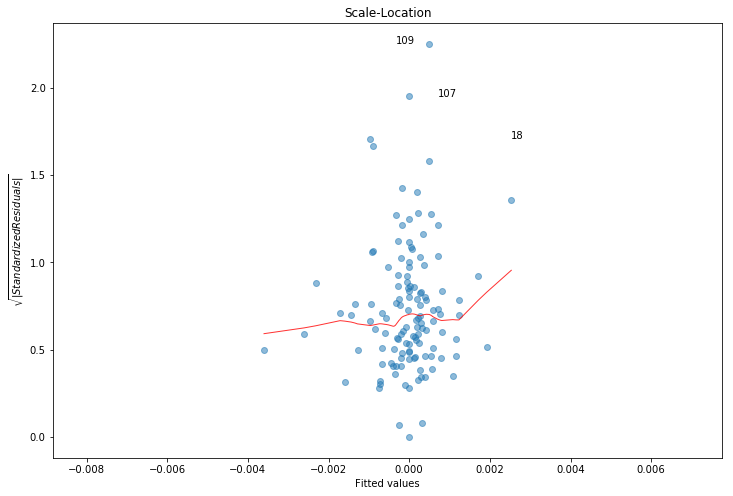

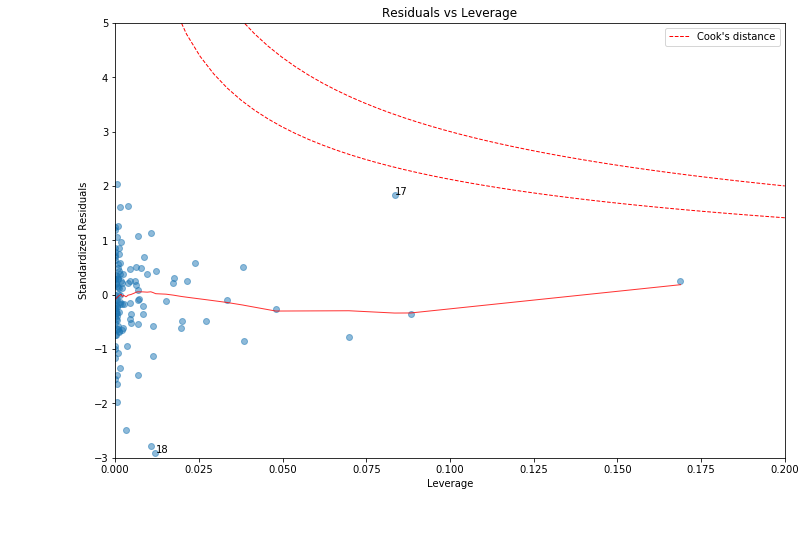

In [54]:
# Instantiate class instance, and display plots
sum_plots = LinearRegressionSummaryPlots(df_sent_DGS10, 'fp2', results_DGS10_fp2)
sum_plots.display_resdiduals_vs_fitted_plot()
sum_plots.display_qq_plot()
sum_plots.display_scale_location_plot()
sum_plots.display_residuals_vs_leverage_plot()

In [56]:
# Read in the data for Linear Regresion
df = pd.read_csv('../derived/Data_for_LinReg.csv',
                 index_col='date',
                 parse_dates=True)
df.head(10)

,sentiment,d1sentiment,CIVPART,CIVPART_bd1,UNRATE,UNRATE_bd1,PCEPILFE,PCEPILFE_bp12,BAA10Y,BAA10Y_fp2,BAA10Y_fp5,T10YIE,T10YIE_fp2,T10YIE_fp5,WILL5000IND,WILL5000IND_fp2,WILL5000IND_fp5,DGS10,DGS10_fp2,DGS10_fp5
date,,,,,,,,,,,,,,,,,,,,
2007-01-31,1.000,NaN,66.4,NaN,4.6,NaN,91.741,NaN,1.57,-0.000000,-0.006452,2.43,-0.000000,-0.021097,52.11,0.012400,0.014843,4.83,-0.008264,-0.023061
2007-03-21,0.000,-1.000,66.2,-0.1,4.4,-0.1,92.032,0.004060,1.73,0.022857,0.028409,2.39,0.016461,0.028455,52.30,0.016444,0.012289,4.53,0.008696,0.012987
2007-05-09,-0.200,-0.200,66.0,-0.3,4.4,0.1,92.272,0.001012,1.65,-0.000000,-0.006061,2.38,0.008403,-0.008547,55.11,-0.010121,-0.005311,4.67,0.004301,0.016985
2007-06-28,0.333,0.533,66.0,0.1,4.6,-0.1,92.424,0.001423,1.60,-0.000000,0.006250,2.39,-0.004202,-0.008439,55.09,-0.001636,0.013078,5.12,-0.011928,-0.007921
2007-08-07,-0.143,-0.476,65.8,0.0,4.6,0.1,92.701,0.001647,1.83,-0.010695,0.010471,2.26,-0.000000,-0.000000,53.71,0.021643,-0.005846,4.77,0.024793,0.012552
2007-09-18,-0.111,0.032,66.0,-0.2,4.7,-0.1,92.954,0.001504,2.11,0.004739,-0.039604,2.31,0.021552,0.013043,55.48,0.034563,0.027422,4.50,0.011038,0.032397
2007-10-31,-0.200,-0.089,65.8,0.2,4.7,0.1,93.196,0.001491,1.99,0.009950,0.019704,2.34,0.008475,0.044898,56.87,-0.014265,-0.007353,4.48,-0.009174,-0.004566
2007-12-11,0.143,0.343,66.0,0.2,5.0,0.0,93.567,0.002603,2.63,0.015209,-0.015686,2.25,0.004405,0.034188,54.32,-0.020879,-0.051301,3.98,-0.024691,0.011905
2008-01-22,-0.500,-0.643,66.2,0.0,5.0,0.3,93.753,0.001964,2.98,0.027119,0.033670,2.24,-0.018182,0.017544,48.11,0.012002,0.025286,3.52,-0.042735,-0.013850


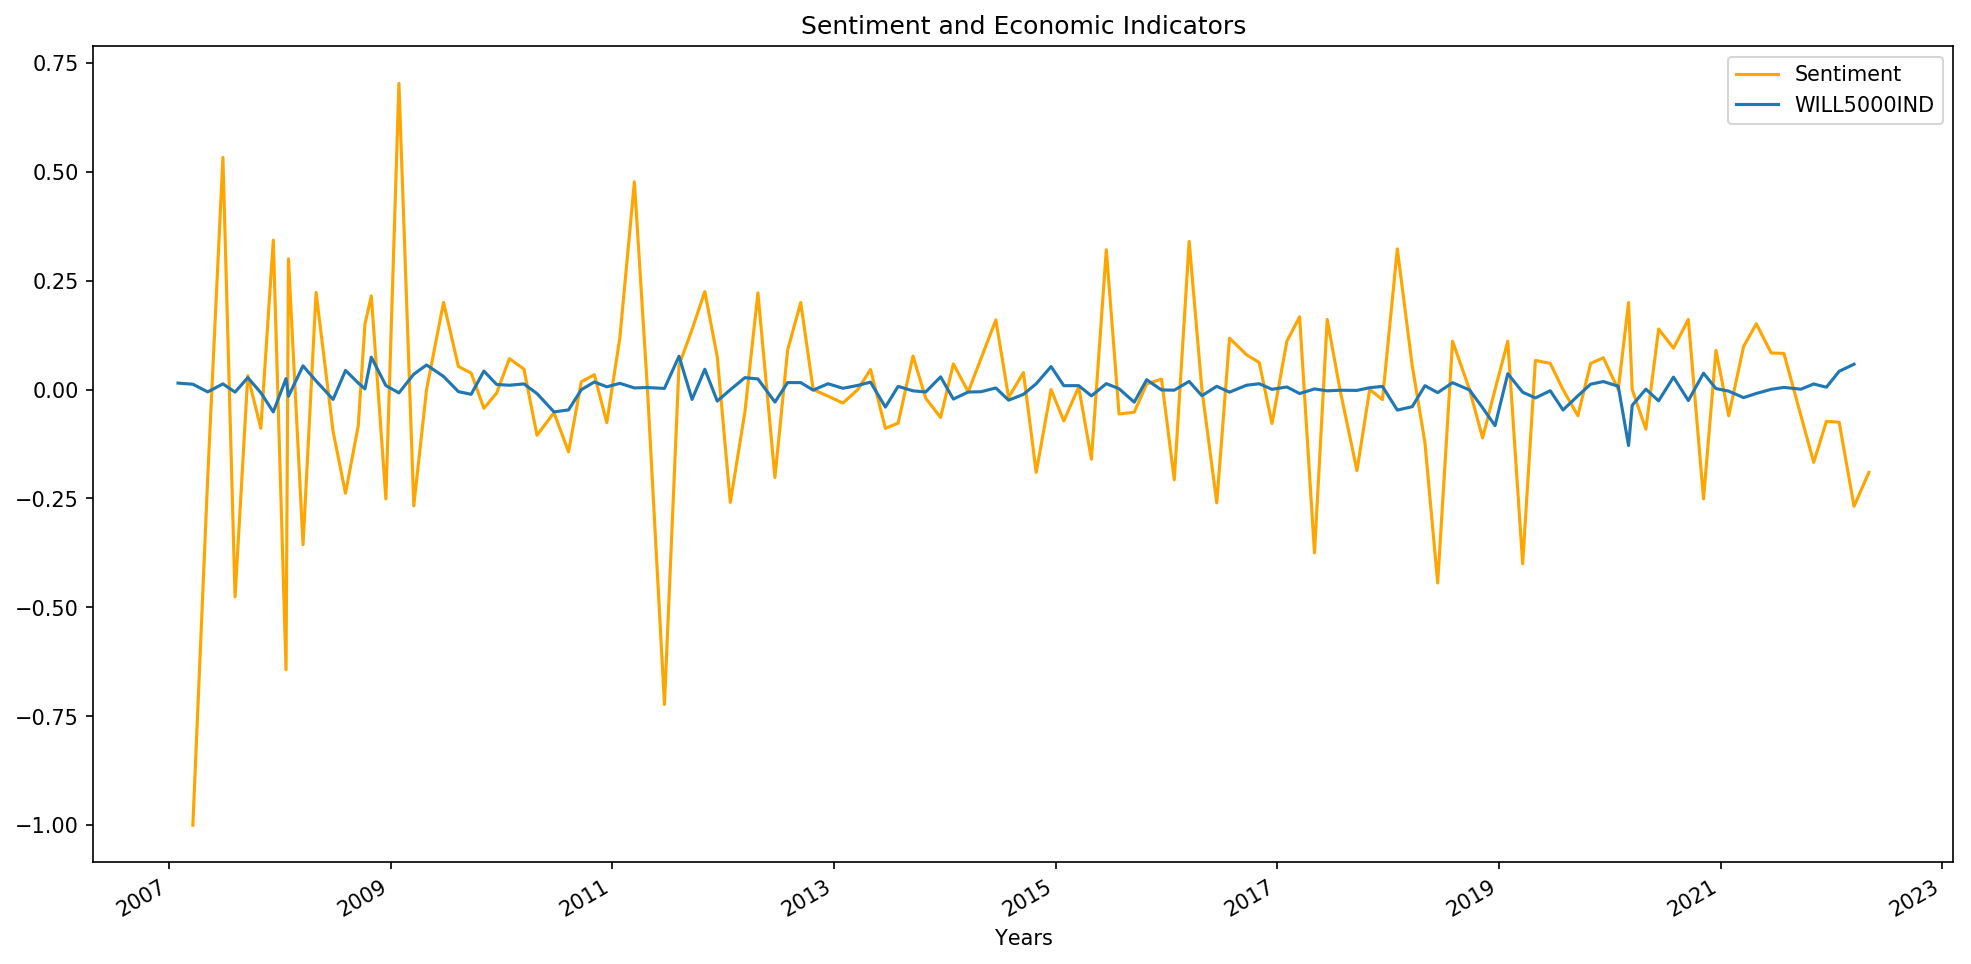

In [57]:
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
  
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline
# code
# Visualizing The Open Price of all the stocks

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
plt.rcParams["figure.figsize"] = (10,8)

# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df['d1sentiment'].plot(label='Sentiment', color='orange')
#df['CIVPART'].plot(label='CIVPART')
#df['UNRATE'].plot(label='UNRATE')
#df['PCEPILFE_bp12'].plot(label='PCEPILFE')
#df['BAA10Y_fp5'].plot(label='BAA10Y')
#df['T10YIE'].plot(label='T10YIE')
df['WILL5000IND_fp5'].plot(label='WILL5000IND')
#df['DGS10'].plot(label='DGS10')

# adding title to the plot
plt.title('Sentiment and Economic Indicators')

# adding Label to the x-axis
plt.xlabel('Years')

# adding legend to the curve
plt.legend()



In [58]:
df['d1sentiment'][0] = 0.0
df['d1sentiment'][1] = -1.0
df['WILL5000IND_fp5'][125] = 0.0
df['zWILL5000IND_fp5'] = zscore(df['WILL5000IND_fp5'])
df['zd1sentiment'] = zscore(df['d1sentiment'])
df.head(3)

,sentiment,d1sentiment,CIVPART,CIVPART_bd1,UNRATE,UNRATE_bd1,PCEPILFE,PCEPILFE_bp12,BAA10Y,BAA10Y_fp2,...,T10YIE_fp2,T10YIE_fp5,WILL5000IND,WILL5000IND_fp2,WILL5000IND_fp5,DGS10,DGS10_fp2,DGS10_fp5,zWILL5000IND_fp5,zd1sentiment
date,,,,,,,,,,,,,,,,,,,,,
2007-01-31,1.0,0.0,66.4,NaN,4.6,NaN,91.741,NaN,1.57,-0.000000,...,-0.000000,-0.021097,52.11,0.012400,0.014843,4.83,-0.008264,-0.023061,0.460573,0.048855
2007-03-21,0.0,-1.0,66.2,-0.1,4.4,-0.1,92.032,0.004060,1.73,0.022857,...,0.016461,0.028455,52.30,0.016444,0.012289,4.53,0.008696,0.012987,0.368122,-4.569100
2007-05-09,-0.2,-0.2,66.0,-0.3,4.4,0.1,92.272,0.001012,1.65,-0.000000,...,0.008403,-0.008547,55.11,-0.010121,-0.005311,4.67,0.004301,0.016985,-0.268920,-0.874736


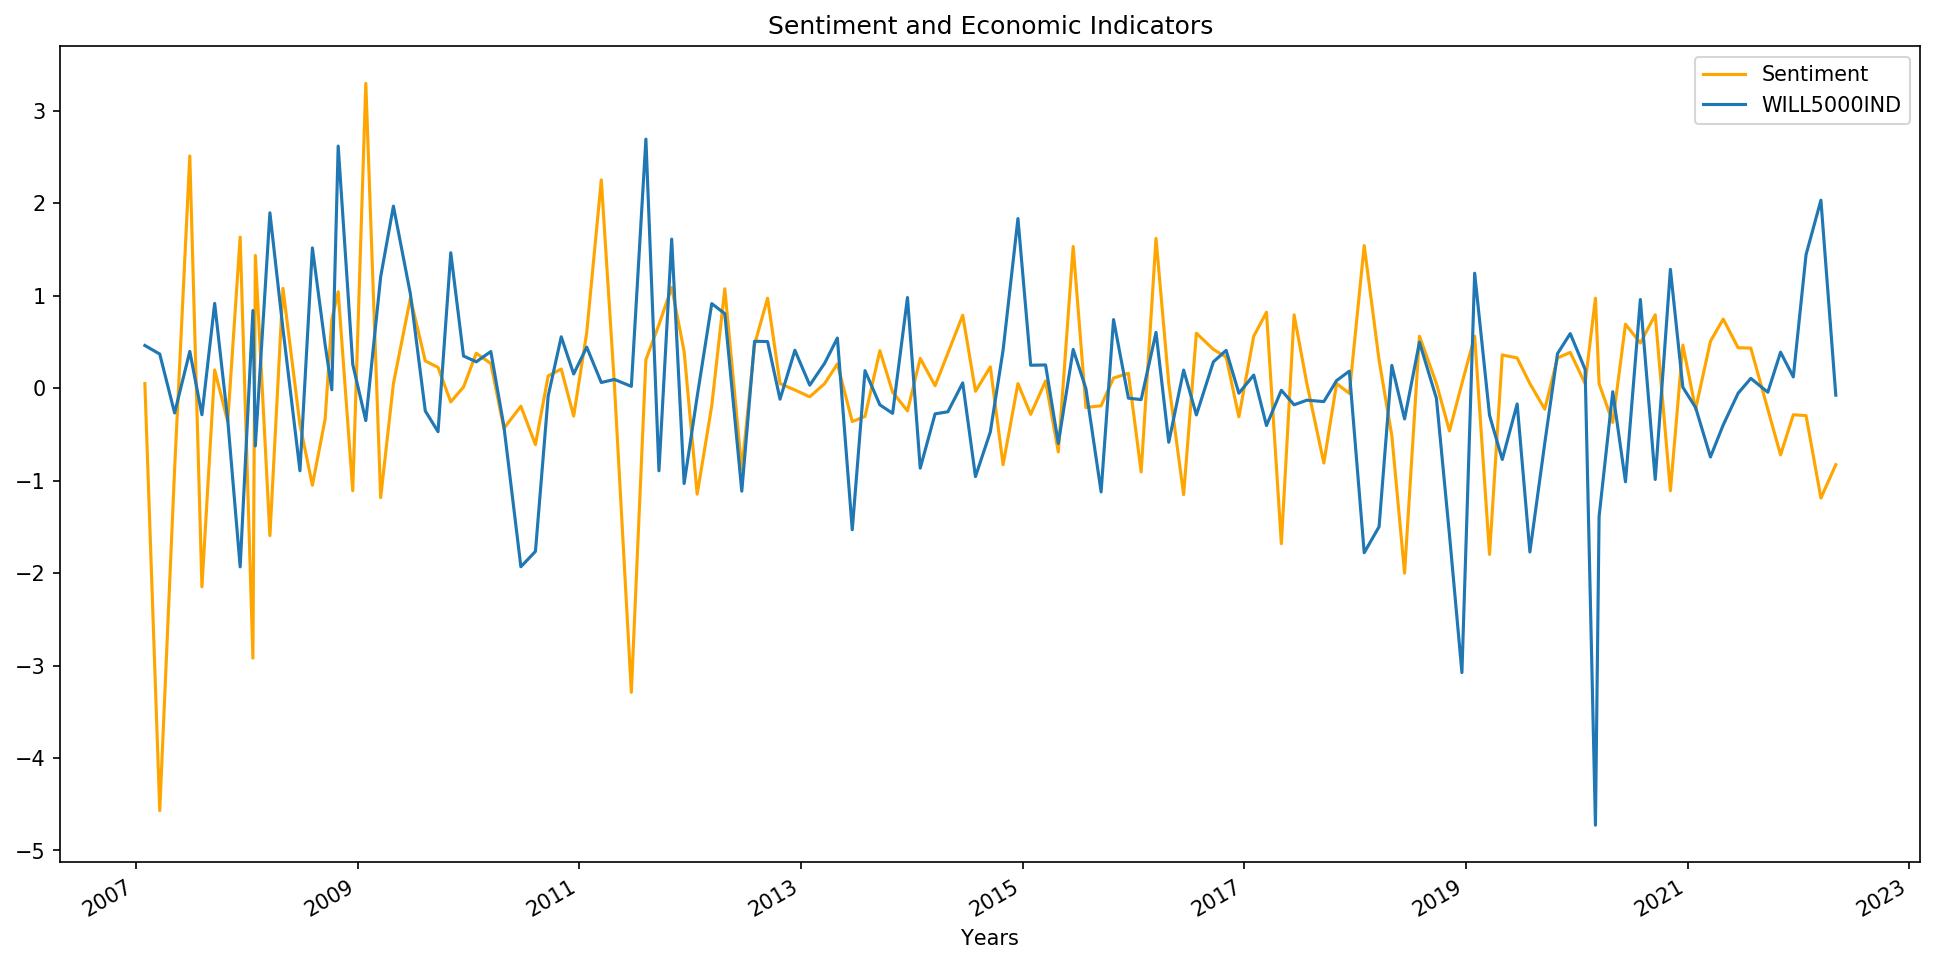

In [59]:
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
  
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline
# code
# Visualizing The Open Price of all the stocks

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
plt.rcParams["figure.figsize"] = (10,8)

# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df['zd1sentiment'].plot(label='Sentiment', color='orange')
df['zWILL5000IND_fp5'].plot(label='WILL5000IND')

# adding title to the plot
plt.title('Sentiment and Economic Indicators')

# adding Label to the x-axis
plt.xlabel('Years')

# adding legend to the curve
plt.legend()

In [60]:
# Generate linear regression model
mod_z_will = sm.OLS(df['zWILL5000IND_fp5'][1:], sm.add_constant(df['zd1sentiment'][1:]), missing='drop')
mod_fit_mod_z_will = mod_z_will.fit()
print(mod_fit_mod_z_will.summary())

                            OLS Regression Results                            
Dep. Variable:       zWILL5000IND_fp5   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.234
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.269
Time:                        15:28:44   Log-Likelihood:                -177.14
No. Observations:                 125   AIC:                             358.3
Df Residuals:                     123   BIC:                             363.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0037      0.090     -0.041   

In [61]:
df['log_base2_will'] = np.log2(df['WILL5000IND'])
df.head(3)

,sentiment,d1sentiment,CIVPART,CIVPART_bd1,UNRATE,UNRATE_bd1,PCEPILFE,PCEPILFE_bp12,BAA10Y,BAA10Y_fp2,...,T10YIE_fp5,WILL5000IND,WILL5000IND_fp2,WILL5000IND_fp5,DGS10,DGS10_fp2,DGS10_fp5,zWILL5000IND_fp5,zd1sentiment,log_base2_will
date,,,,,,,,,,,,,,,,,,,,,
2007-01-31,1.0,0.0,66.4,NaN,4.6,NaN,91.741,NaN,1.57,-0.000000,...,-0.021097,52.11,0.012400,0.014843,4.83,-0.008264,-0.023061,0.460573,0.048855,5.703488
2007-03-21,0.0,-1.0,66.2,-0.1,4.4,-0.1,92.032,0.004060,1.73,0.022857,...,0.028455,52.30,0.016444,0.012289,4.53,0.008696,0.012987,0.368122,-4.569100,5.708739
2007-05-09,-0.2,-0.2,66.0,-0.3,4.4,0.1,92.272,0.001012,1.65,-0.000000,...,-0.008547,55.11,-0.010121,-0.005311,4.67,0.004301,0.016985,-0.268920,-0.874736,5.784242


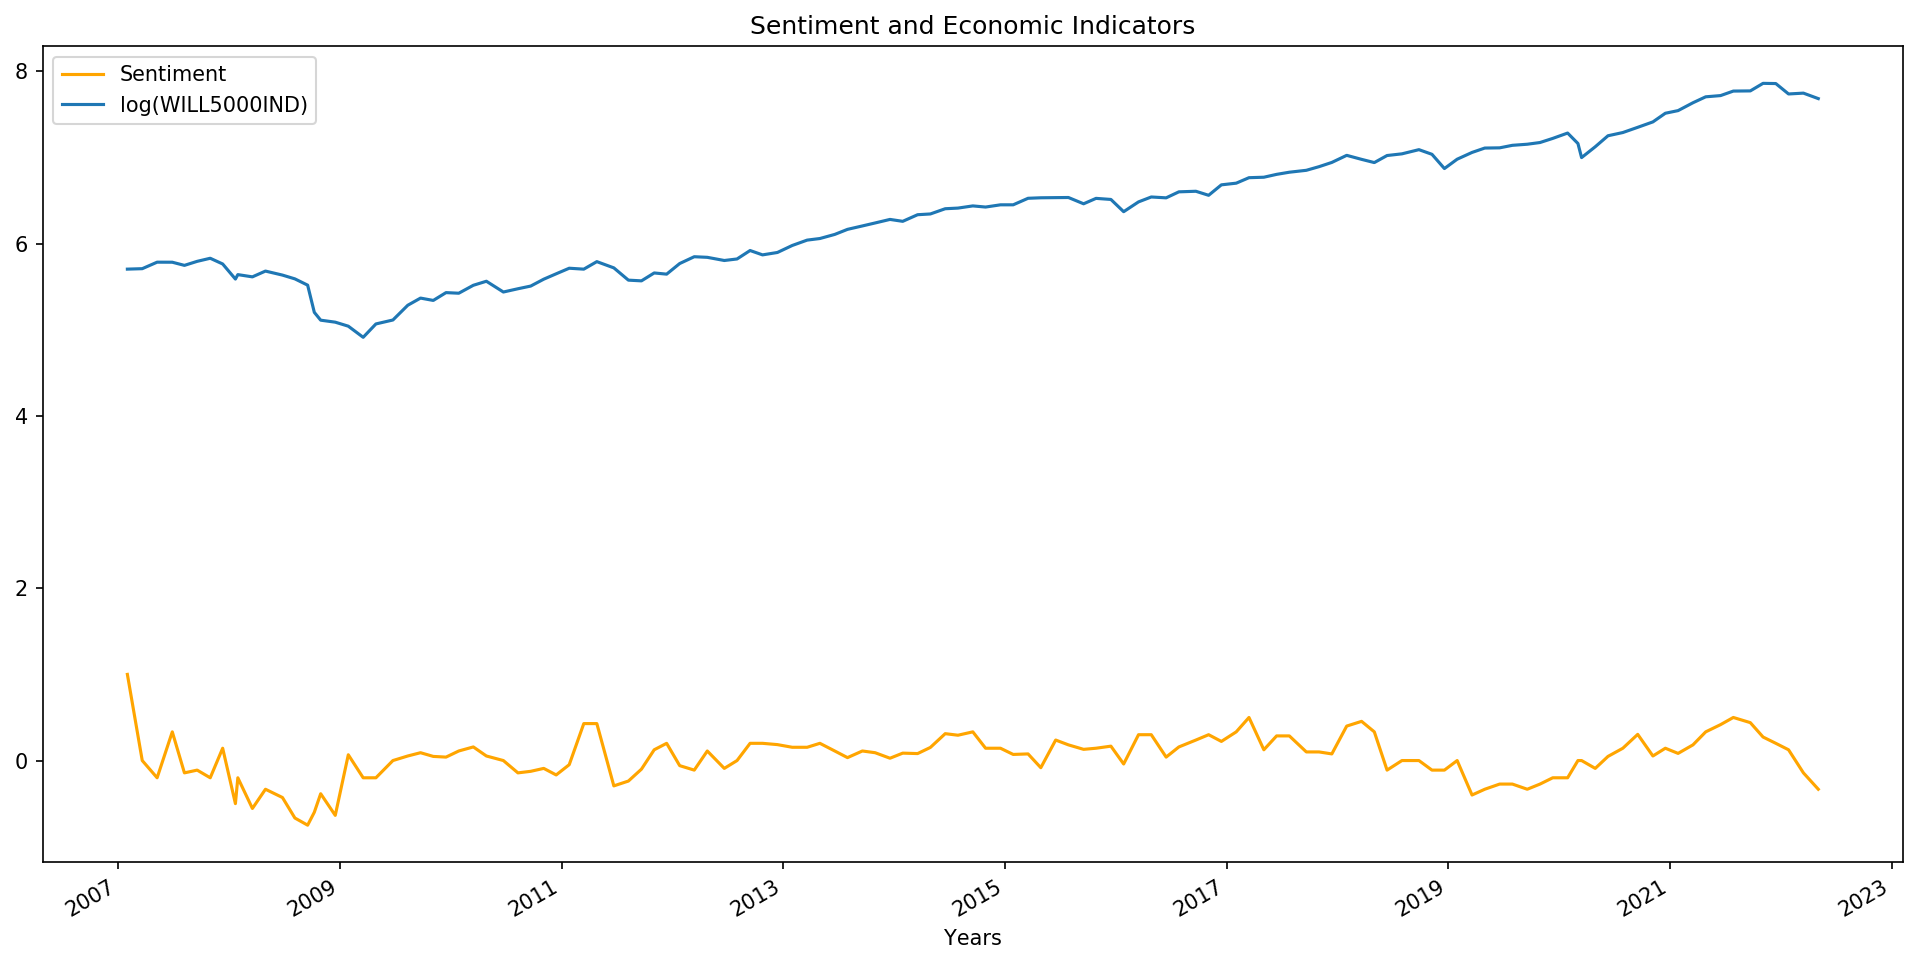

In [62]:
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
  
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline
# code
# Visualizing The Open Price of all the stocks

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
plt.rcParams["figure.figsize"] = (10,8)

# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df['sentiment'].plot(label='Sentiment', color='orange')
#df['CIVPART'].plot(label='CIVPART')
#df['UNRATE'].plot(label='UNRATE')
#df['PCEPILFE_bp12'].plot(label='PCEPILFE')
#df['BAA10Y_fp5'].plot(label='BAA10Y')
#df['T10YIE'].plot(label='T10YIE')
df['log_base2_will'].plot(label='log(WILL5000IND)')
#df['DGS10'].plot(label='DGS10')

# adding title to the plot
plt.title('Sentiment and Economic Indicators')

# adding Label to the x-axis
plt.xlabel('Years')

# adding legend to the curve
plt.legend()




In [63]:
import scipy.stats as stats
df['zlog_base2_will'] = stats.zscore(df['log_base2_will'])
df['zsentiment'] = stats.zscore(df['sentiment'])
df.head(3)

,sentiment,d1sentiment,CIVPART,CIVPART_bd1,UNRATE,UNRATE_bd1,PCEPILFE,PCEPILFE_bp12,BAA10Y,BAA10Y_fp2,...,WILL5000IND_fp2,WILL5000IND_fp5,DGS10,DGS10_fp2,DGS10_fp5,zWILL5000IND_fp5,zd1sentiment,log_base2_will,zlog_base2_will,zsentiment
date,,,,,,,,,,,,,,,,,,,,,
2007-01-31,1.0,0.0,66.4,NaN,4.6,NaN,91.741,NaN,1.57,-0.000000,...,0.012400,0.014843,4.83,-0.008264,-0.023061,0.460573,0.048855,5.703488,-0.859649,3.640461
2007-03-21,0.0,-1.0,66.2,-0.1,4.4,-0.1,92.032,0.004060,1.73,0.022857,...,0.016444,0.012289,4.53,0.008696,0.012987,0.368122,-4.569100,5.708739,-0.852754,-0.129309
2007-05-09,-0.2,-0.2,66.0,-0.3,4.4,0.1,92.272,0.001012,1.65,-0.000000,...,-0.010121,-0.005311,4.67,0.004301,0.016985,-0.268920,-0.874736,5.784242,-0.753612,-0.883263


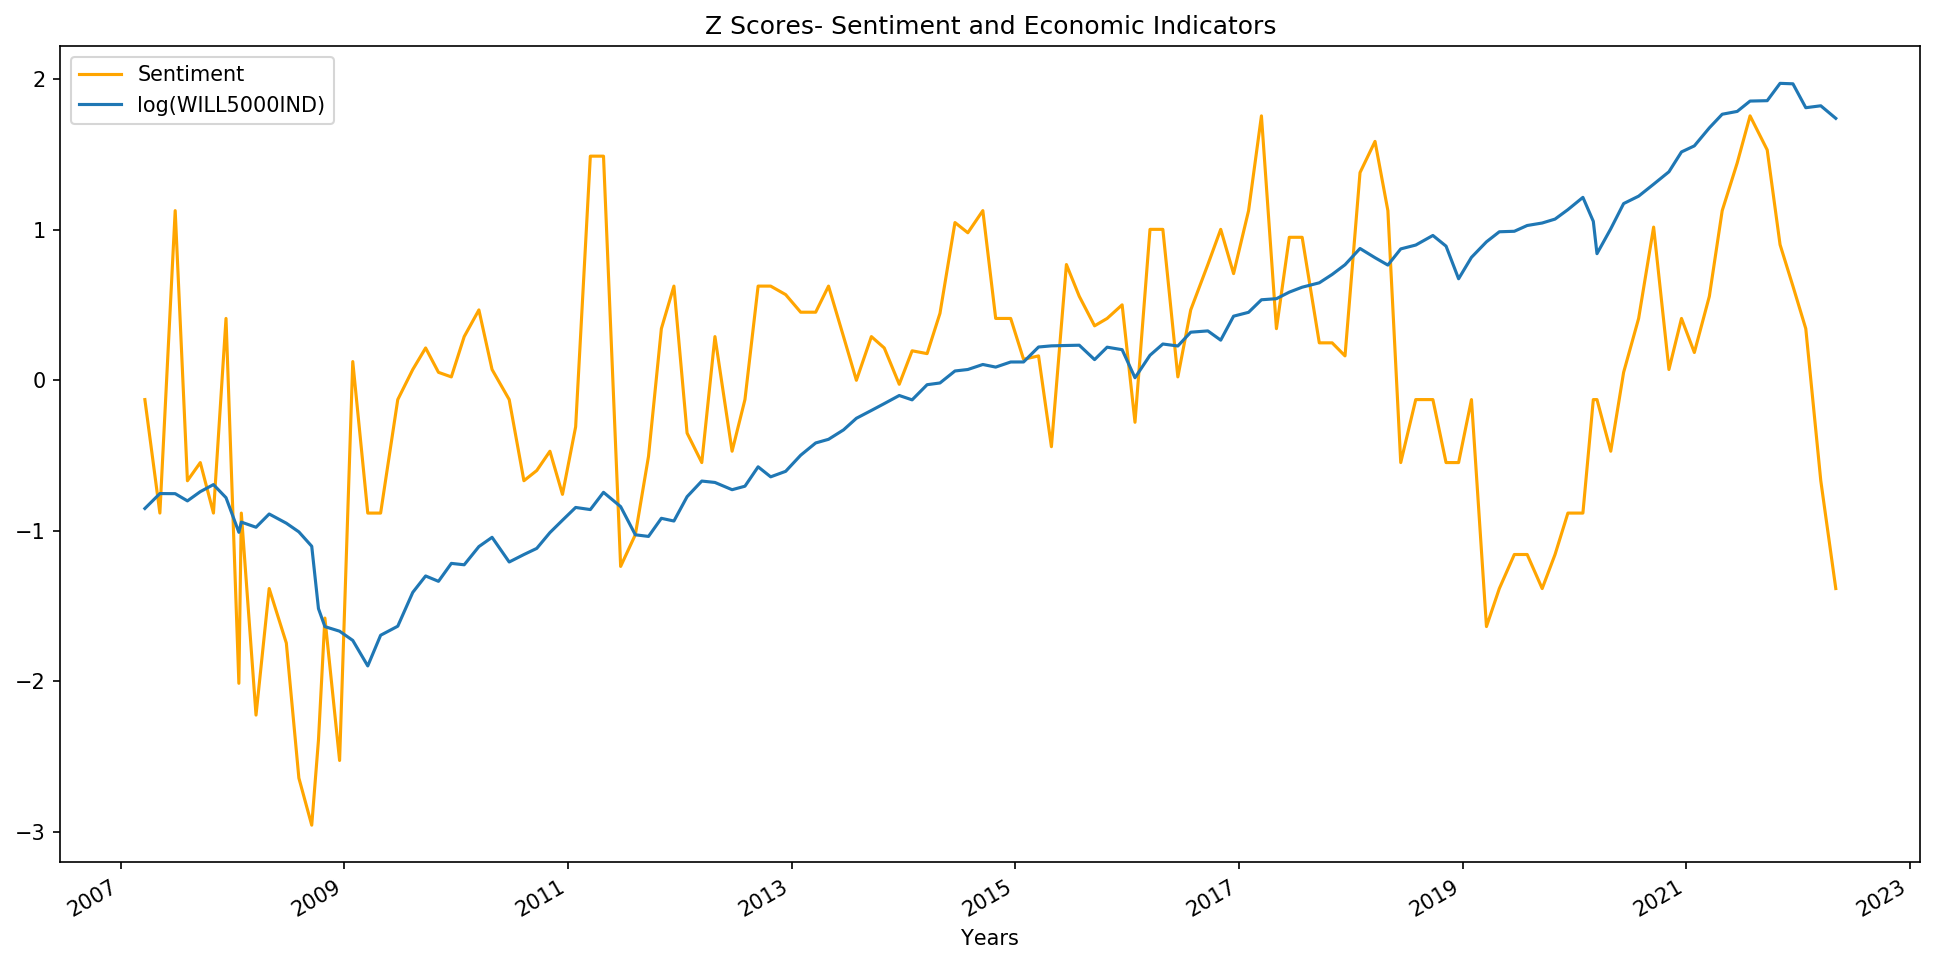

In [64]:
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
  
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline
# code
# Visualizing The Open Price of all the stocks

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
plt.rcParams["figure.figsize"] = (10,8)

# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df['zsentiment'][1:].plot(label='Sentiment', color='orange')
df['zlog_base2_will'][1:].plot(label='log(WILL5000IND)')

# adding title to the plot
plt.title('Z Scores- Sentiment and Economic Indicators')

# adding Label to the x-axis
plt.xlabel('Years')

# adding legend to the curve
plt.legend()





In [65]:
# Generate linear regression model
mod_z_will = sm.OLS(df['zlog_base2_will'][1:], sm.add_constant(df['zsentiment'][1:]), missing='drop')
mod_fit_mod_z_will = mod_z_will.fit()
print(mod_fit_mod_z_will.summary())

                            OLS Regression Results                            
Dep. Variable:        zlog_base2_will   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     15.22
Date:                Fri, 13 May 2022   Prob (F-statistic):           0.000156
Time:                        15:28:46   Log-Likelihood:                -170.20
No. Observations:                 125   AIC:                             344.4
Df Residuals:                     123   BIC:                             350.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0171      0.085      0.200      0.8

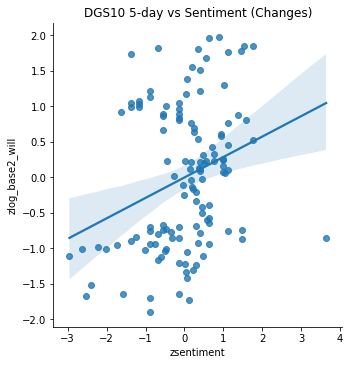

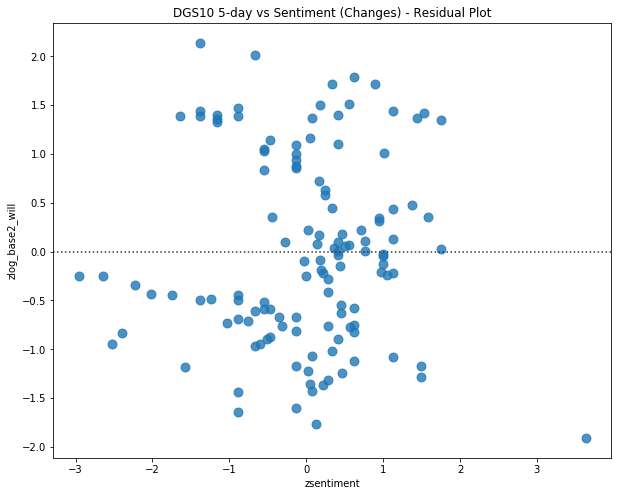

In [66]:
sns.lmplot( x= 'zsentiment', y = "zlog_base2_will", data = df, fit_reg=True, legend=True)
plt.title("DGS10 5-day vs Sentiment (Changes)")
plt.show()

sns.residplot( x= 'zsentiment', y = "zlog_base2_will", data = df, scatter_kws={"s": 80})
plt.title("DGS10 5-day vs Sentiment (Changes) - Residual Plot")
plt.show()

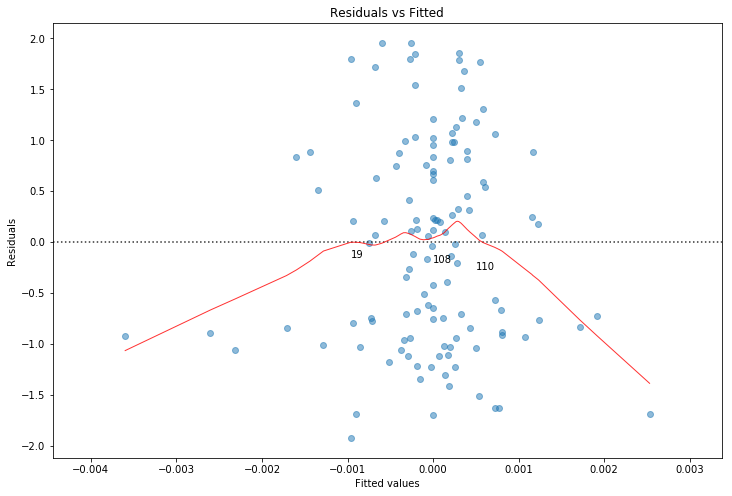

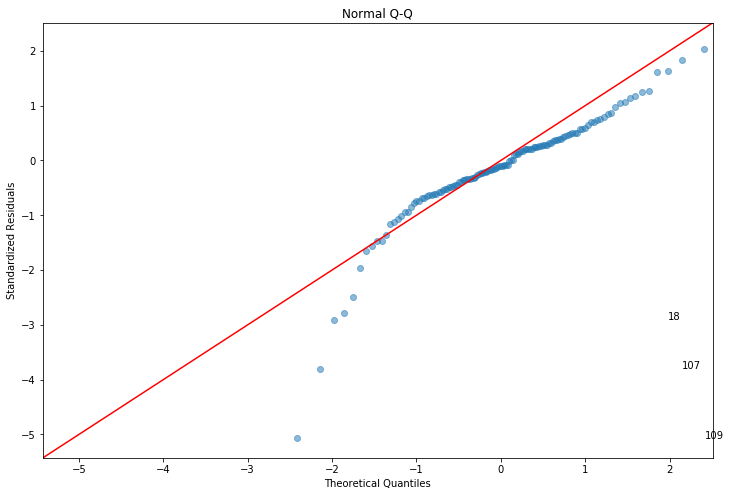

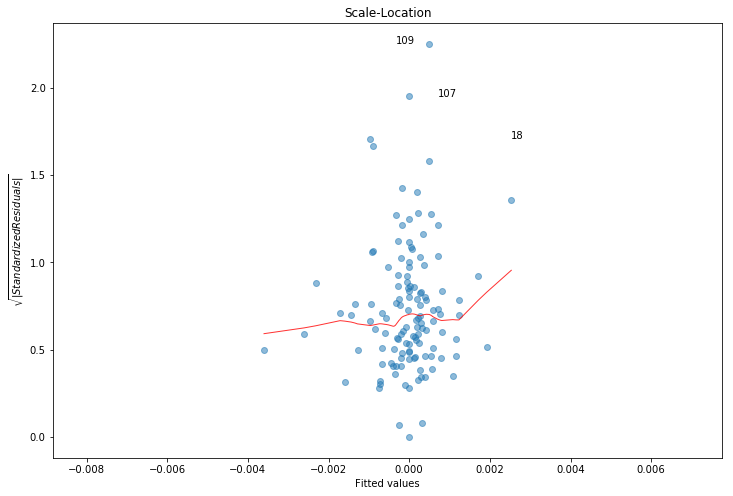

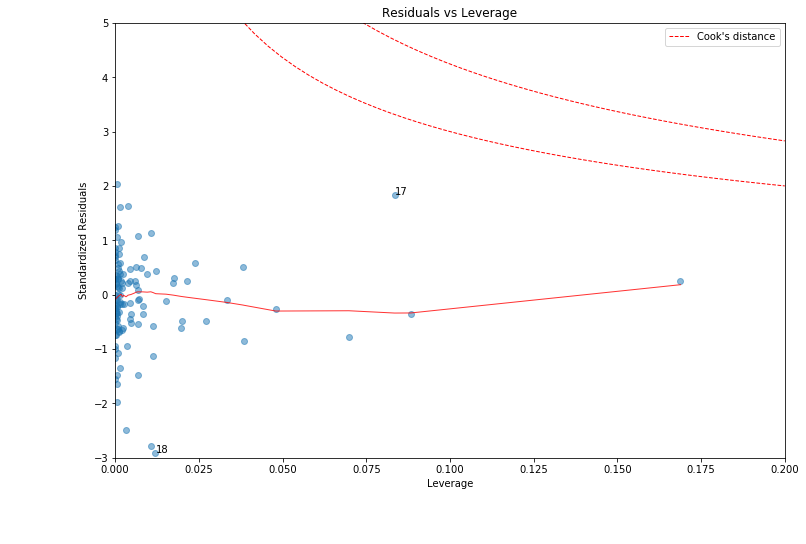

In [67]:


# Instantiate class instance, and display plots
sum_plots = LinearRegressionSummaryPlots(df, 'zlog_base2_will', mod_fit_mod_z_will)
sum_plots.display_resdiduals_vs_fitted_plot()
sum_plots.display_qq_plot()
sum_plots.display_scale_location_plot()
sum_plots.display_residuals_vs_leverage_plot()